In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

#from nltk.corpus import stopwords
# preprocess words
import nltk
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils, to_categorical
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.externals import joblib
from gensim.models.keyedvectors import KeyedVectors

import time

from keras.layers import Input, Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional, MaxPooling1D, Conv1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
import h5py


# model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.utils import compute_class_weight




# snippet of using the ReduceLROnPlateau callback
from keras.callbacks import ReduceLROnPlateau
# import these modules
from nltk.stem import WordNetLemmatizer
# split into words
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/table_for_nlp_analysis.csv')

In [7]:
# df = pd.read_csv("table_for_nlp_analysis.csv")

In [8]:
# rename columns

col_list_new = ['overall', 'reviewtext', 'asin']
col_list_old = ['for_nlp_analysis.overall', 'for_nlp_analysis.reviewtext', 'for_nlp_analysis.asin']
col_replacement = dict(zip(col_list_old, col_list_new))

df.rename(columns = col_replacement, inplace = True)

In [9]:
df = df.dropna(subset=['reviewtext'])

Text(0, 0.5, 'Count')

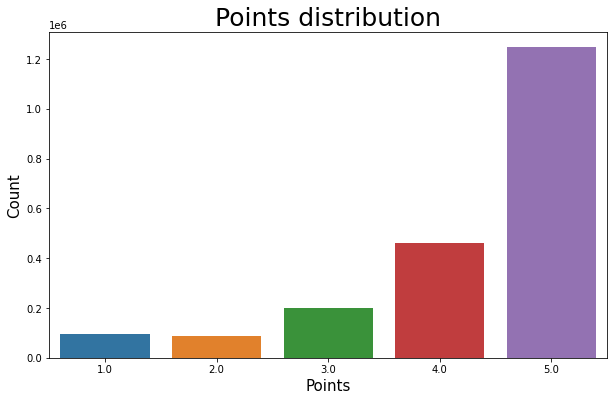

In [10]:
plt.figure(figsize=(10,6))
points_plot = sns.countplot(x='overall', data=df)
points_plot.set_title("Points distribution", fontsize=25)
points_plot.set_xlabel("Points", fontsize=15)
points_plot.set_ylabel("Count", fontsize=15) 

In [11]:
# merge two dicts x and y into z: z = {**x, **y}

In [12]:
# df['overall'] = df['overall'].map(lambda x: x-1)

In [13]:
lab_vals = [1, 2, 3, 4, 5]
new_lab_vals = [0, 0, 1, 2, 2]

di_map = dict(zip(lab_vals, new_lab_vals))

di_map = dict(zip(lab_vals, new_lab_vals))
df['overall'] = df['overall'].map(di_map)

Text(0, 0.5, 'Count')

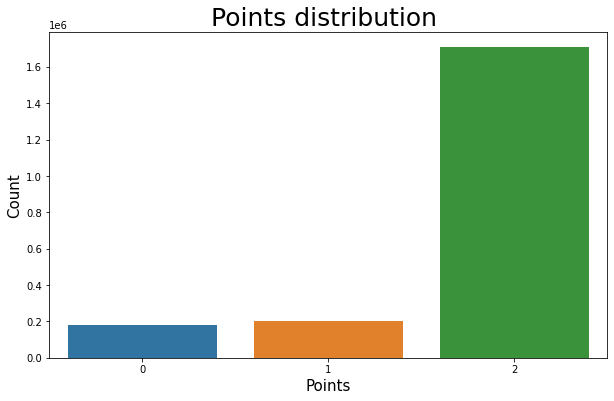

In [14]:
plt.figure(figsize=(10,6))
points_plot = sns.countplot(x='overall', data=df)
points_plot.set_title("Points distribution ", fontsize=25)
points_plot.set_xlabel("Points", fontsize=15)
points_plot.set_ylabel("Count", fontsize=15) 

In [15]:
df['reviewtext'] = df['reviewtext'].str.lower()

In [16]:
# Reviews (feature Description in the dataset) - correlation of the length of the review with the rating

In [17]:
desc_length = df['reviewtext'].apply(len)

print(f"The longest description contains: {desc_length.max()} characters")
print(f"The shortest description contains: {desc_length.min()} characters")
print(f"Median number of characters is: {desc_length.median()}")
print(f"Standard deviation of reviews: {np.std(desc_length)}")

The longest description contains: 8141 characters
The shortest description contains: 1 characters
Median number of characters is: 135.0
Standard deviation of reviews: 195.6603269086265


In [18]:
df = df.assign(desc_length = df['reviewtext'].apply(len))

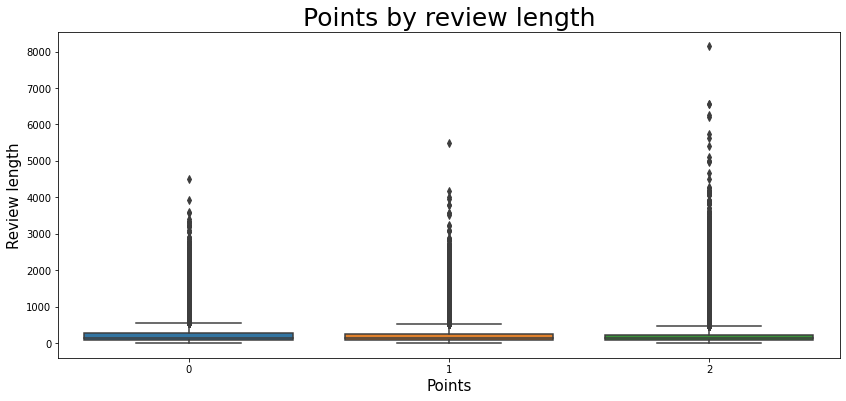

In [19]:
plt.figure(figsize=(14,6))
points_length = sns.boxplot(x='overall', y='desc_length', data=df)
points_length.set_title('Points by review length', fontsize=25)
points_length.set_ylabel('Review length', fontsize = 15)
points_length.set_xlabel('Points', fontsize = 15) 
plt.show()

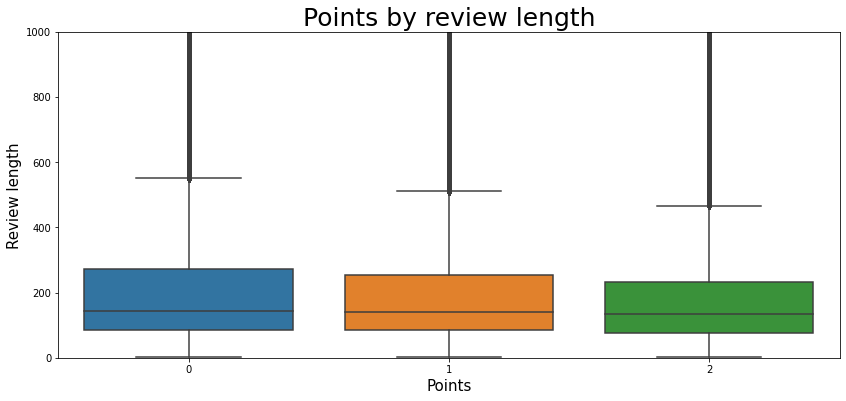

In [20]:
plt.figure(figsize=(14,6))
points_length = sns.boxplot(x='overall', y='desc_length', data=df)
points_length.set_title('Points by review length', fontsize=25)
points_length.set_ylabel('Review length', fontsize = 15)
points_length.set_xlabel('Points', fontsize = 15) 
points_length.set_ylim([0,1000])
plt.show()

In [21]:
# interestingly there is no correlation of the length of the review and the rating assigned

In [22]:
# this dataset is rather large - take a random sample of the wordcloud, hence going forward, I will take
# a sample of the dataset

In [23]:
df2 = df.sample(n = 500000, random_state=42)
#df2 = df

In [24]:
# WordCloud of reviews shows most common words in reviews excluding stopwords.

In [25]:
# stopwords = set(STOPWORDS)
# newStopWords = ["book", "read", "story", "character", "read", "series", "time", "reading", "author"]
# stopwords.update(newStopWords)

In [26]:
# wordcloud = WordCloud(
#     background_color='white',
#     stopwords=stopwords,
#     max_words=300,
#     max_font_size=100, 
#     width=1000, height=800,
#     random_state=42,
# ).generate(" ".join(df2['reviewtext']))

# print(wordcloud)
# fig = plt.figure(figsize = (12,14))
# plt.imshow(wordcloud)
# plt.title("WordCloud - Kindle Reviews",fontsize=25)
# plt.axis('off')
# plt.show()

# Train Test Split

In [27]:
# lowest class needs to be 0 for the to_categorical replacement
#df2['overall'] = df2.overall.apply(lambda x: x-1)

In [28]:
# Some Preprocessing

In [29]:
df2.head()

,overall,reviewtext,asin,desc_length
906069,2,great read for younger readers - still enterta...,B00EFWU9QY,103
153301,2,i am saying this because all of lee child's bo...,B00ZRDPPU0,129
1491557,0,"first, this book is riddled with distracting t...",B00CAE71L0,777
688726,2,this story is by far my absolute favorite from...,B006KD2TP0,230
1521821,1,great,B016X4TTP8,5


In [30]:
# 3.step: removing the stopwords
stopwords_1 = STOPWORDS

In [31]:
# no_list = ['no', 'nor', 'not']

In [32]:
# keep_stops = [e for e in stopwords_1 if e.endswith("n't")] + [e for e in stopwords_1 if e.endswith("n'")]\
#                 + [e for e in stopwords_1 if e.endswith("n") and len(e)>=4] + no_list

In [33]:
# keep_stops

In [34]:
#stopwords = set(list(set(stopwords_1) - set(keep_stops)))
stopwords = set(stopwords_1) 

In [35]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

In [36]:
df2.reviewtext = df2.reviewtext.map(lambda x: word_tokenize(x))

# ps = PorterStemmer()
# df2['stemmed'] = df2.reviewtext.apply(lambda x: [ps.stem(y) for y in x]) # Stem every word.

lemmatizer = WordNetLemmatizer()
df2['reviewtext'] = df2['reviewtext'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x]) # Stem every word.

In [37]:
def remove_stopwords (df, colname, stopwords = stopwords):

    #split words / tokenise
    #df[colname] = list(map(lambda x: x.lower().split(), df[colname]))
    #df[colname] = list(map(lambda x: word_tokenize(x), df[colname]))

    #lemmatise
    #df[colname] = list(map(lambda line: list(map(lambda word: lemmatizer.lemmatize(word), line)), df[colname]))

    #remove stopwords
    df[colname] = list(map(lambda line: list(filter(lambda word: word not in stopwords, line)), df[colname]))

    #join back to 'full sentence' form
    df[colname] = list(map(lambda x: " ".join(x), df[colname]))
    
    return df

In [38]:
df2 = remove_stopwords(df = df2, colname = 'reviewtext')

In [39]:
#df2.head()

In [40]:
X = df2["reviewtext"]
y = df2["overall"]
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                          random_state=random_state, stratify = y, shuffle = True)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, 
#                                                           random_state=random_state)

# Text preprocessing



First, in order to conduct topic analysis I have to preprocess reviews of wines:




In [41]:
# tokenizing and filtering out basic punctuation and setting to lowercase
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [42]:
# dictionary mapping words (str) to their index (int)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")
print(word_index)

Found 90289 unique tokens.
{'book': 1, 'wa': 2, 'read': 3, 'story': 4, "n't": 5, "'s": 6, 'good': 7, 'love': 8, 'great': 9, 'one': 10, 'character': 11, 'series': 12, 'reading': 13, 'really': 14, 'will': 15, 'loved': 16, 'time': 17, 'author': 18, 'well': 19, 'ha': 20, 'enjoyed': 21, 'first': 22, 'next': 23, 'much': 24, "''": 25, 'way': 26, 'life': 27, 'ca': 28, 'wait': 29, 'written': 30, 'make': 31, 'put': 32, 'end': 33, 'recommend': 34, 'know': 35, 'want': 36, 'short': 37, 'little': 38, 'interesting': 39, "'m": 40, 'lot': 41, 'keep': 42, 'many': 43, 'see': 44, 'even': 45, 'thing': 46, 'easy': 47, 'think': 48, 'fun': 49, 'find': 50, 'new': 51, 'doe': 52, 'two': 53, 'writing': 54, 'liked': 55, 'thought': 56, 'plot': 57, 'go': 58, 'romance': 59, 'looking': 60, 'another': 61, 'page': 62, 'work': 63, 'now': 64, 'never': 65, "'ve": 66, 'better': 67, 'people': 68, 'found': 69, 'going': 70, 'novel': 71, 'enjoy': 72, 'got': 73, 'give': 74, 'forward': 75, 'best': 76, 'always': 77, 'need': 78, 'p

In [43]:
# turning texts into sequences (list of word indexes)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
#sequences_val = tokenizer.texts_to_sequences(X_val)

In [44]:
sequences_train

[[2521, 147, 28, 5, 29, 28, 5, 29, 5857, 6, 1, 82, 16],
 [3874,
  2925,
  1,
  9,
  556,
  158,
  33,
  4,
  163,
  704,
  42,
  567,
  36,
  299,
  112,
  91,
  156,
  263,
  565,
  124,
  51,
  15,
  321,
  72,
  1],
 [98, 1222, 1785, 468, 1, 12, 5689, 10561, 98, 87, 179, 119],
 [8],
 [9, 3, 8, 1299, 58, 8, 18, 43, 9, 4, 245, 622, 298, 1837, 10, 9, 1],
 [4,
  2,
  37,
  1251,
  471,
  416,
  130,
  269,
  3705,
  128,
  3679,
  10751,
  59,
  4,
  227,
  4511,
  610,
  1928,
  27,
  1735,
  288,
  352,
  1069,
  4709,
  5858,
  25,
  1350,
  39,
  5375,
  37,
  4,
  2,
  43,
  1262,
  25,
  8436,
  3705,
  128,
  4,
  958,
  404,
  3,
  18,
  12,
  34,
  828,
  96],
 [362, 456, 2, 21, 6776],
 [9, 4, 1645, 520, 1, 3],
 [16, 1, 11, 493, 163, 209, 136, 2, 5, 32],
 [38, 1576, 433, 186],
 [21, 158, 33],
 [14, 56, 1472, 104, 1197, 1594, 91, 79, 1178, 423, 423, 14, 31, 900],
 [785],
 [296, 443],
 [3348,
  9,
  23399,
  152,
  308,
  348,
  1503,
  6071,
  150,
  2,
  1042,
  26,
  131,
  2,

In [45]:
# checking the length of the longest review
max_len = max([len(x) for x in sequences_train+sequences_test])
print(f"The longest description has {max_len} words.")

The longest description has 519 words.


In [46]:
# padding sequences so that they are of equal length
X_train_nn = sequence.pad_sequences(sequences_train, maxlen = max_len)
X_test_nn = sequence.pad_sequences(sequences_test, maxlen = max_len)
#X_val_nn = sequence.pad_sequences(sequences_val, maxlen = max_len)

In [47]:
X_train_nn

array([[   0,    0,    0, ...,    1,   82,   16],
       [   0,    0,    0, ...,  321,   72,    1],
       [   0,    0,    0, ...,   87,  179,  119],
       ...,
       [   0,    0,    0, ...,  248, 1542,  919],
       [   0,    0,    0, ...,  138,    2,   13],
       [   0,    0,    0, ..., 1025,   37,    4]], dtype=int32)

In [48]:
## turning y into one-hots
nb_classes = len(y_train.unique()) # equal to a number of labels
y_train_nn = np_utils.to_categorical(y_train, nb_classes)
y_test_nn = np_utils.to_categorical(y_test, nb_classes)
#y_val_nn = np_utils.to_categorical(y_val, nb_classes)

In [49]:
# !wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [50]:
#!unzip glove.42B.300d.zip

In [51]:
#  def load_glove_model(glove_input_file, word2vec_output_file="/content/drive/MyDrive/Colab Notebooks/gensim_glove_vectors.txt"):
#      glove2word2vec(glove_input_file, word2vec_output_file)
#      return KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [52]:
from datetime import datetime

In [53]:
start_time = time.time()
print(datetime.fromtimestamp(start_time))

#glove_model = load_glove_model("/content/drive/MyDrive/Colab Notebooks/glove.42B.300d.txt")

glove_model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Colab Notebooks/gensim_glove_vectors.txt", binary=False)
#glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

2021-05-02 09:37:55.520701
--- 16.859494324525198 minutes ---


In [54]:
len(word_index)+1

90290

In [55]:
# code to download, unzip, preprocess and load pre-trained Glove model with embeddings
# I saved an array of filetered embeddings and load it below 


start_time = time.time()
print(start_time)
input_dim = len(word_index)+1 # This is the size of the vocabulary in the text data.
output_dim = 300 # This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
#output_dim = int(3/5*max_len)
# creating embedding matrix containing only embeddings for words used in wines reviews

emb_matrix = np.zeros((input_dim, output_dim))
for w, i in word_index.items():
  try:
    vect = glove_model[w]
    if vect is not None:
      emb_matrix[i] = vect
  except:
    pass


joblib.dump(emb_matrix, "emb_matrix.joblib")
print("--- %s seconds ---" % (time.time() - start_time))

1619949287.1814759
--- 0.8509666919708252 seconds ---


In [56]:
# checking how many words from wines reviews are reprezented in pre-trained Glove Embeddings
print(len(([key for key in word_index.keys() if key in glove_model]))/len(word_index))

0.794493238378983


In [57]:
emb_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38600999, -0.030722  ,  0.010253  , ...,  0.69549   ,
         0.10035   , -0.31393999],
       [ 0.62946999,  0.04394   ,  0.46744001, ...,  0.11883   ,
         0.32545   ,  0.38670999],
       ...,
       [ 0.24144   ,  0.45765999, -0.049159  , ...,  0.67040998,
        -0.43446001, -0.70637   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [58]:
emb_matrix.shape

(90290, 300)

### Training the model

In [59]:
# model = Model(inputs = input, outputs = x)
# model.shape

In [60]:
class_weights_numpy = compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [61]:
keys_cl_weights = np.unique(y_train).tolist()

In [62]:
values_cl_weights = class_weights_numpy.tolist()

In [63]:
class_weights = dict(zip(keys_cl_weights, values_cl_weights))

In [64]:
class_weights

{0: 3.8503700885132135, 1: 3.471201280669084, 2: 0.40779708017290595}

In [65]:
emb_matrix.shape

(90290, 300)

In [66]:
def build_model(list_of_layers):

    input_1 = Input(shape = (max_len,))

    x = Embedding(input_dim = emb_matrix.shape[0], 
                  output_dim = emb_matrix.shape[1], 
                  input_length = max_len, #This is the length of input sequences
                  weights = [emb_matrix], 
                  trainable = False)(input_1)

    
    for layer in list_of_layers:
        x = layer(x)
        
    model = Model(inputs = input_1, outputs = x)  
    model.summary()

    model.compile(loss = "categorical_crossentropy", 
                  optimizer = "adam", 
                  metrics = ["categorical_accuracy"])
    
    
    #model = load_model(str(filename)+".h5py")

    return model

In [67]:
def evaluate_model(model, X_train, X_val, y_train, y_val, filename, batch_size=128):

    ext = ".h5py"# ".ckpt" # ".h5py"

    import tensorflow as tf

    rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_delta=1E-7, cooldown = 1, verbose = 1)
    early_stopping = EarlyStopping(patience=5, monitor="val_loss")
    take_best_model = ModelCheckpoint(str(filename)+ext, monitor = "val_loss", verbose = 1, save_best_only=True)

    history = model.fit(X_train, y_train, epochs=100, validation_split=0.2,
              batch_size=batch_size, 
              callbacks=[rlrp, early_stopping, take_best_model], class_weight = class_weights)
    
    model = load_model(str(filename)+ext)
    
    # predict probabilities for test set
    y_prob = model.predict(X_val, verbose=0)
    
    # predict crisp classes for test set
    y_pred = np.round(np.argmax(y_prob, axis=1)).astype(int)

    # accuracy: (tp + tn) / (p + n)
    acc = accuracy_score(y_val, y_pred)  
    # precision tp / (tp + fp) # a lot of false positives - lowers precision of the model
    precision = precision_score(y_val, y_pred, average='weighted')
    #print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_val, y_pred, average='weighted')
    #print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_val, y_pred, average='weighted')
    #print('F1 score: %f' % f1)
    
    return acc, precision, recall, f1

In [68]:
models = {  
          # "clf_LSTM_500n":      
          #                       [LSTM(500),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],
           
          # "clf_BiLSTM_500n":      
          #                       [Bidirectional(LSTM(500)),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],    
            
          # "clf_LSTM_500n_MultipleDense":      
          #                       [LSTM(500),
          #                        Dropout(0.5),
          #                        Dense(30, activation="relu"),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],
    
          # "clf_BiLSTM_500n_MultipleDense":      
          #                       [Bidirectional(LSTM(500)),
          #                        Dropout(0.5),
          #                        Dense(30, activation="relu"),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],
          
          # "clf_CNN1D_500n_BiLSTM_MultipleDense":      
          #                       [Conv1D(32, kernel_size=2, padding='valid', input_shape=(1000, 1)),
          #                        MaxPooling1D(pool_size=2),
          #                        Bidirectional(LSTM(500)),
          #                        Dense(30, activation="relu"),
          #                        Dropout(0.5),
          #                        Dense(nb_classes, activation="softmax")],
          
          "clf_BiLSTM_500n_CNN1D_MultipleDense":      
                                [Bidirectional(LSTM(500, return_sequences=True)),
                                 Conv1D(32, kernel_size=3, padding='valid'),
                                 MaxPooling1D(pool_size=2),
                                 Dense(30, activation="relu"),
                                 Dropout(0.5),
                                 Flatten(),
                                 Dense(nb_classes, activation="softmax")]
}



In [ ]:
results_df = pd.DataFrame()

for model_name, layer_params in models.items():
    out = pd.DataFrame([list(evaluate_model(build_model(layer_params), X_train_nn, X_test_nn, y_train_nn, y_test, filename = model_name))], columns = ['accuracy', 'precision', 'recall', 'f1-score'])
    results_df = results_df.append(out)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 519)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 519, 300)          27087000  
_________________________________________________________________
bidirectional (Bidirectional (None, 519, 1000)         3204000   
_________________________________________________________________
conv1d (Conv1D)              (None, 517, 32)           96032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 258, 32)           0         
_________________________________________________________________
dense (Dense)                (None, 258, 30)           990       
_________________________________________________________________
dropout (Dropout)            (None, 258, 30)           0     

INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 2/100
2657/2657 [==============================] - 1359s 511ms/step - loss: 0.7000 - categorical_accuracy: 0.7536 - val_loss: 0.5593 - val_categorical_accuracy: 0.7752

Epoch 00002: val_loss improved from 0.61268 to 0.55935, saving model to clf_BiLSTM_500n_CNN1D_MultipleDense.h5py


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


INFO:tensorflow:Assets written to: clf_BiLSTM_500n_CNN1D_MultipleDense.h5py/assets


Epoch 3/100
2627/2657 [============================>.] - ETA: 14s - loss: 0.6509 - categorical_accuracy: 0.7690

In [ ]:
results = results_df.copy()
results['model'] = list(models.keys())
results = results.sort_values(by="f1-score", ascending=False).reset_index(drop=True)

In [ ]:
results

In [ ]:
model_winner = load_model("clf_BiLSTM_500n_CNN1D_MultipleDense.h5py")

In [ ]:
# predict probabilities for test set
y_prob = model_winner.predict(X_test_nn)

In [ ]:
# predict crisp classes for test set
y_pred = np.round(np.argmax(y_prob, axis=1)).astype(int)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
cm/cm.sum(axis = 1, keepdims = True)

### Load previously trained models and evaluate results

In [ ]:
# def evaluate_loaded_model(filename, X_val, y_val):

#     ext = ".h5py" # ".ckpt" # .h5py
    
#     model = load_model(str(filename)+ext)
    
#     # predict probabilities for test set
#     y_prob = model.predict(X_val, verbose=0)
    
#     # predict crisp classes for test set
#     y_pred = np.round(np.argmax(y_prob, axis=1)).astype(int)
    
#     # accuracy: (tp + tn) / (p + n)
#     acc = accuracy_score(y_val, y_pred)
    
#     # precision tp / (tp + fp)
#     precision = precision_score(y_val, y_pred, average='weighted')
    
#     # print('Precision: %f' % precision)
#     # recall: tp / (tp + fn)
#     recall = recall_score(y_val, y_pred, average='weighted')
    
#     # print('Recall: %f' % recall)
#     # f1: 2 tp / (2 tp + fp + fn)
#     f1 = f1_score(y_val, y_pred, average='weighted')
#     #print('F1 score: %f' % f1)
    
#     return acc, precision, recall, f1

In [ ]:
# results_df_loaded = pd.DataFrame()

# for model in models.keys():
#     print(model)
#     out = pd.DataFrame([list(evaluate_loaded_model(filename = model, X_val = X_test_nn, y_val = y_test))], columns = ['accuracy', 'precision', 'recall', 'f1-score'])
#     results_df_loaded = results_df_loaded.append(out)

In [ ]:
# results_loaded = results_df_loaded.copy()
# results_loaded['model'] = list(models.keys())
# results_loaded = results_loaded.sort_values(by="f1-score", ascending=False).reset_index(drop=True)
# results_loaded

In [ ]:
# Score on test set
# let's check how the best model scores on the test set

In [ ]:
# Training the 'winner' network architechture only on the full dataset

In [ ]:
# model_winner = load_model("clf_LSTM_500n.h5py") #.ckpt #.h5py

In [ ]:
# model_winner.evaluate(X_test_nn, y_test_nn)

In [ ]:
# # confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

In [ ]:
# cm/cm.sum(axis = 1, keepdims = True)